In [2]:
import sys
sys.path.append("/Users/nrahaman/Python/info-bazaar")
sys.path.append("/Users/nrahaman/Python/speedrun")

In [16]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import product
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from bazaar.lem_utils import ask_for_guidance, clean_program_string, get_llm, get_closed_book_answer
from bazaar.py_utils import dump_dict, load_dict

In [4]:
def compute_win_rate(budget): 
    results = load_dict(f"./assets/verdicts_gpt4_fup-v3-vs-noinspect_budget-{budget}.json")
    num_wins = sum([(1 if v["verdict"] == "B" else 0) for v in results])
    num_total = len(results)
    win_rate = num_wins / num_total
    return win_rate

In [12]:
budgets = [10, 25, 50, 100, 200]
win_rates = [compute_win_rate(b) for b in budgets]

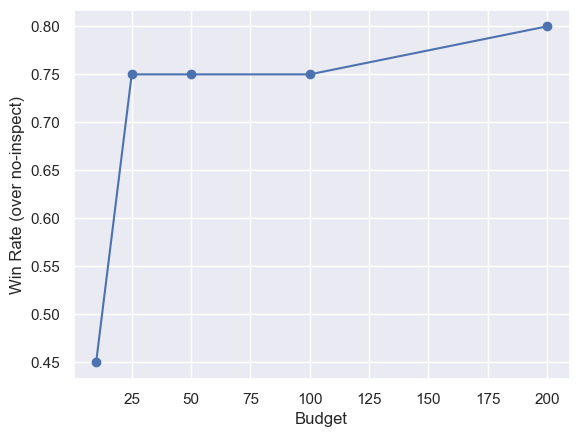

In [13]:
plt.figure()
plt.plot(budgets, win_rates, marker="o")
plt.xlabel("Budget")
plt.ylabel("Win Rate (over no-inspect)")
plt.show()

In [14]:
noinspect_path = Path("/Users/nrahaman/Downloads/likert_debate_eval_gpt-3.5-turbo_fupnoinspect-STAR-RemoteLlama-2-70b-chat-hf-STAR.csv")
normal_path = Path("/Users/nrahaman/Downloads/likert_debate_eval_gpt-3.5-turbo_fup-v3-STAR-RemoteLlama-2-70b-chat-hf-STAR.csv")

noinspect_df = pd.read_csv(noinspect_path)
normal_df = pd.read_csv(normal_path)

In [15]:
def keep_at_budget(df, budget): 
    return df[df["budget"].round() == budget]


def keep_at_question(df, question): 
    return df[df["question"] == question]

In [16]:
rows = []

for budget in budgets: 
    results = load_dict(f"./assets/verdicts_gpt4_fup-v3-vs-noinspect_budget-{budget}.json")
    for verdict in results: 
        question = verdict["question"]
        row_a = keep_at_budget(keep_at_question(noinspect_df, question), budget)
        row_b = keep_at_budget(keep_at_question(normal_df, question), budget)
        assert row_a.shape[0] == row_b.shape[0] == 1
        win = verdict["verdict"] == "B"
        price_a = row_a.iloc[0].credit_spent
        price_b = row_b.iloc[0].credit_spent
        rows.append(
            dict(
                player="normal", 
                question=question, 
                credit_spent=price_b, 
                quality=int(verdict["verdict"] == "B")
            )
        )
        rows.append(
            dict(
                player="noinspect", 
                question=question, 
                credit_spent=price_a, 
                quality=int(verdict["verdict"] == "A")
            )
        )

In [17]:
df = pd.DataFrame(rows)

In [19]:
df.to_csv("./assets/inspection_games.csv")

In [20]:
data_sorted = df.sort_values(by='credit_spent')
cumulative_data = data_sorted.groupby('player').apply(lambda x: x.assign(cum_quality=x['quality'].cumsum()))


/var/folders/f1/8sn11n6j4nn19h4w2dflk0ch0000gq/T/ipykernel_21766/4030010369.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cumulative_data = data_sorted.groupby('player').apply(lambda x: x.assign(cum_quality=x['quality'].cumsum()))


In [21]:
cumulative_data

,player,question,credit_spent,quality,cum_quality
199,noinspect,What is the name of the architecture that has ...,0.000000,0,0
30,normal,What is the name of the approach that bootstra...,0.000000,0,0
79,noinspect,What is the name of the architecture that has ...,0.000000,0,0
21,noinspect,"What is the meaning of ""emergent capabilities""...",0.000000,0,0
111,noinspect,What is the name of the approach that bootstra...,0.000000,0,0
...,...,...,...,...,...
180,normal,"What is the meaning of ""emergent capabilities""...",199.805081,1,67
196,normal,What is the difference between continuous prom...,199.863172,1,68
195,noinspect,How do the performances of different language ...,199.894463,0,30
192,normal,What are some ways to ensure that machine lear...,203.591913,1,69


In [30]:
legend_remap = {"normal": "With Inspection", "noinspect": "Without Inspection"}

cumulative_data["player"] = cumulative_data["player"].apply(lambda x: legend_remap.get(x, x))
cumulative_data = cumulative_data[cumulative_data["credit_spent"] <= 200]

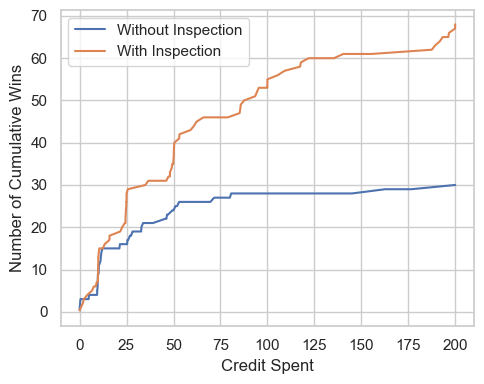

In [50]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.set_style("whitegrid")
sns.lineplot(data=cumulative_data, x='credit_spent', y='cum_quality', hue='player', ax=ax)
plt.xlabel("Credit Spent")
plt.ylabel("Number of Cumulative Wins")
legend = ax.legend()
# legend.texts[0].set_text("Setting")
plt.tight_layout()
plt.savefig("./assets/with_or_without_inspection.pdf")
plt.show()


In [51]:
# Get the Elo plotto

In [52]:
elo_df = pd.read_csv("./assets/elo_scores_data.csv")

In [54]:
elo_df["Budget"]

0      5
1     50
2    100
3    200
Name: Budget, dtype: int64

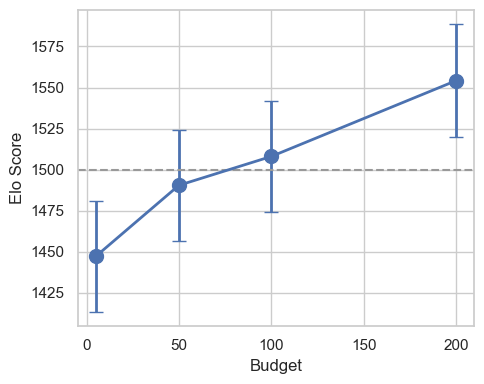

In [70]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.errorbar(elo_df["Budget"], elo_df["Mean_Elo_Score"], yerr=elo_df["Std_Deviation"], fmt='-o', capsize=5, linewidth=2, markersize=10)
ax.set_xlabel("Budget")
ax.set_ylabel("Elo Score")
ax.axhline(y=1500, linestyle="--", c="#999999")
plt.tight_layout()
# plt.savefig("./assets/budget_match.pdf")
plt.show()


In [4]:
hoomaneval = load_dict("./assets/verdicts_pre-humaneval_w_martin.json")

In [8]:
hoomaneval = [v for v in hoomaneval if "human_verdict_nasim" in v and "human_verdict_martin" in v]

In [9]:
nasim_martin_agree = len([v for v in hoomaneval if v["human_verdict_nasim"] == v["human_verdict_martin"]])
nasim_gpt_agree = len([v for v in hoomaneval if v["human_verdict_nasim"] == v["verdict"]])
martin_gpt_agree = len([v for v in hoomaneval if v["human_verdict_martin"] == v["verdict"]])

In [10]:
print(nasim_martin_agree)
print(nasim_gpt_agree)
print(martin_gpt_agree)

37
35
38


In [18]:
# N - M - G
arr = np.eye(3)
arr[0, 1] = 37 / 50
arr[0, 2] = 35 / 50
arr[1, 0] = arr[0, 1]
arr[1, 2] = 38 / 50
arr[2, 0] = arr[0, 2]
arr[2, 1] = arr[1, 2]

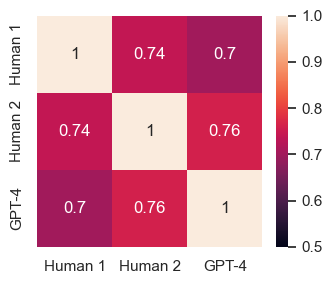

In [45]:
fig, ax = plt.subplots(figsize=(3.5, 3))
sns.heatmap(
    arr, 
    vmin=0.5, 
    vmax=1, 
    annot=True,
    ax=ax,
    # mask=arr_mask,
    xticklabels=["Human 1", "Human 2", "GPT-4"], 
    yticklabels=["Human 1", "Human 2", "GPT-4"],
)
plt.tight_layout()
plt.savefig("./assets/humaneval.pdf")
plt.show()